In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-03-28 15:22:00.616750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:22:01.117735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wireplane = "U"
path = 'processed_data/current/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/current/mean_U.npy',
 'processed_data/current/y_test_ROI_U.npy',
 'processed_data/current/std_U.npy',
 'processed_data/current/y_train_ROI_U.npy',
 'processed_data/current/y_train_AE_U.npy',
 'processed_data/current/x_train_U.npy',
 'processed_data/current/x_test_U.npy',
 'processed_data/current/y_test_AE_U.npy']

In [3]:
x_train = np.load(path+'x_train_' + wireplane + '.npy')
x_test = np.load(path+'x_test_' + wireplane + '.npy')
y_train = np.load(path+'y_train_ROI_' + wireplane + '.npy')
y_test = np.load(path+'y_test_ROI_U.npy')

In [4]:
print(x_test.shape, y_train.shape, y_test.shape, y_train.shape)

(100000, 200) (100000,) (100000,) (100000,)


In [5]:
#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(80000, 200) (80000,)
(100000, 200) (100000,)
(20000, 200) (20000,)


In [7]:
mean = x_train.mean()
std = x_train.std()

In [8]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std

In [9]:
#np.save("latest_models/mean_"+wireplane+"_nu", mean)
#np.save("latest_models/scale_"+wireplane+"_nu", std)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [11]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block                                      
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model

In [12]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

2023-03-28 15:22:05.222695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:22:05.262059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:22:05.262118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:22:05.265019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 15:22:05.265067: I tensorflow/compile

In [13]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [14]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(80000, 200, 1) (20000, 200, 1) (100000, 200, 1)


In [15]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [16]:
#%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100


2023-03-28 15:22:10.537302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-03-28 15:22:13.406741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 7s 22ms/step - loss: 0.4617 - accuracy: 0.7783 - val_loss: 0.3193 - val_accuracy: 0.8676
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3029 - accuracy: 0.8787 - val_loss: 0.2712 - val_accuracy: 0.8929
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2765 - accuracy: 0.8906 - val_loss: 0.2665 - val_accuracy: 0.8935
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2683 - accuracy: 0.8934 - val_loss: 0.2603 - val_accuracy: 0.8968
Epoch 5/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2627 - accuracy: 0.8961 - val_loss: 0.2519 - val_accuracy: 0.9011
Epoch 6/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2593 - accuracy: 0.8981 - val_loss: 0.2526 - val_accuracy: 0.9006
Epoch 7/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2576 - accuracy: 0.8996 - val_loss: 0.2486 - val_accuracy: 0.9028
Epoch 8/100
40/40 [=====

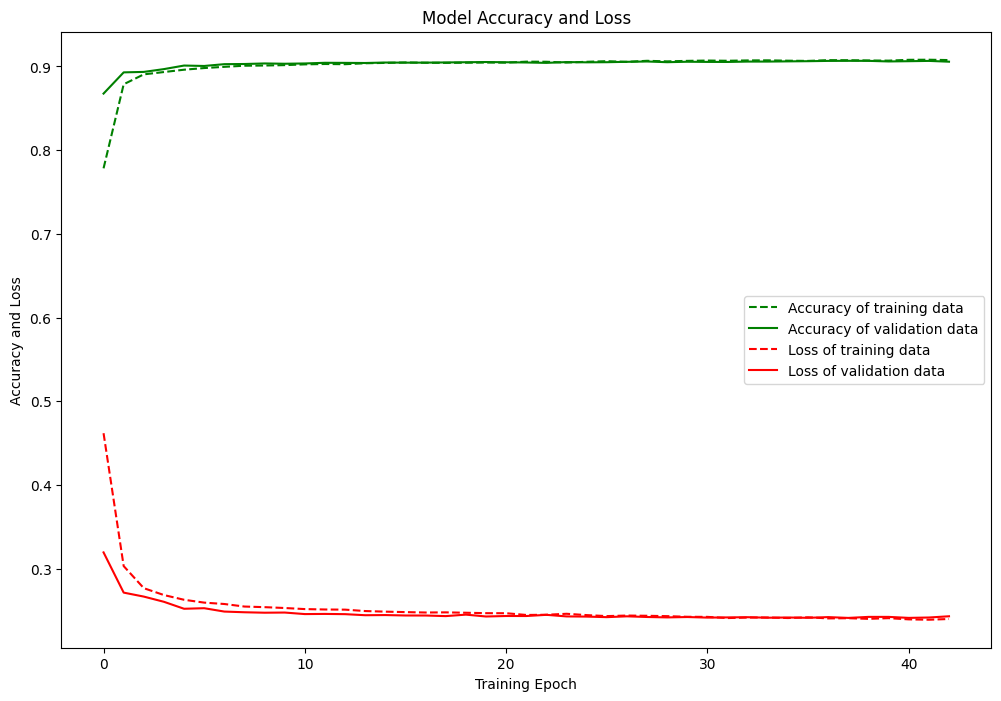

In [17]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [18]:
#del x_train

import gc
gc.collect()

5566

In [ ]:
#model.save("latest_models/model_" + wireplane + "plane_nu.h5")

In [19]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

25/25 [==============================] - 1s 7ms/step - loss: 0.2396 - accuracy: 0.9077


[0.2395976334810257, 0.9076700210571289]

In [20]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [22]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

79/79 [==============================] - 0s 2ms/step
CPU times: user 411 ms, sys: 181 ms, total: 592 ms
Wall time: 555 ms


<Axes: >

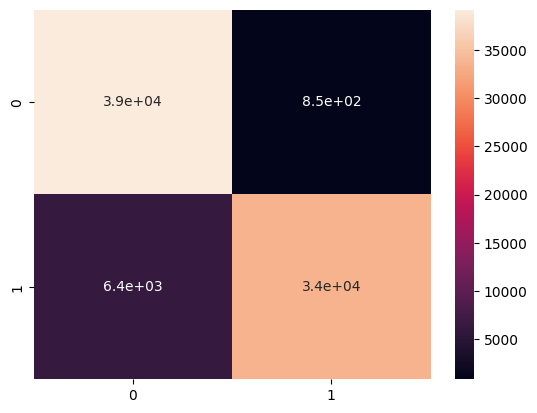

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<Axes: >

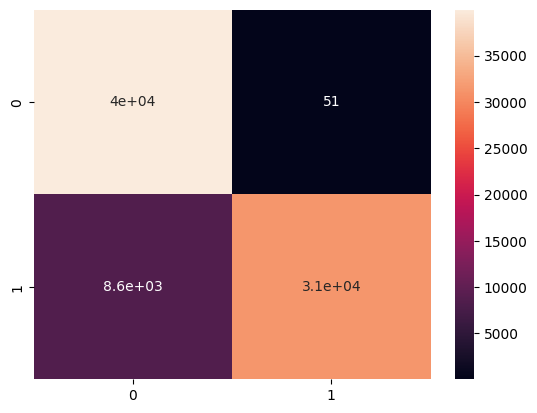

In [24]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

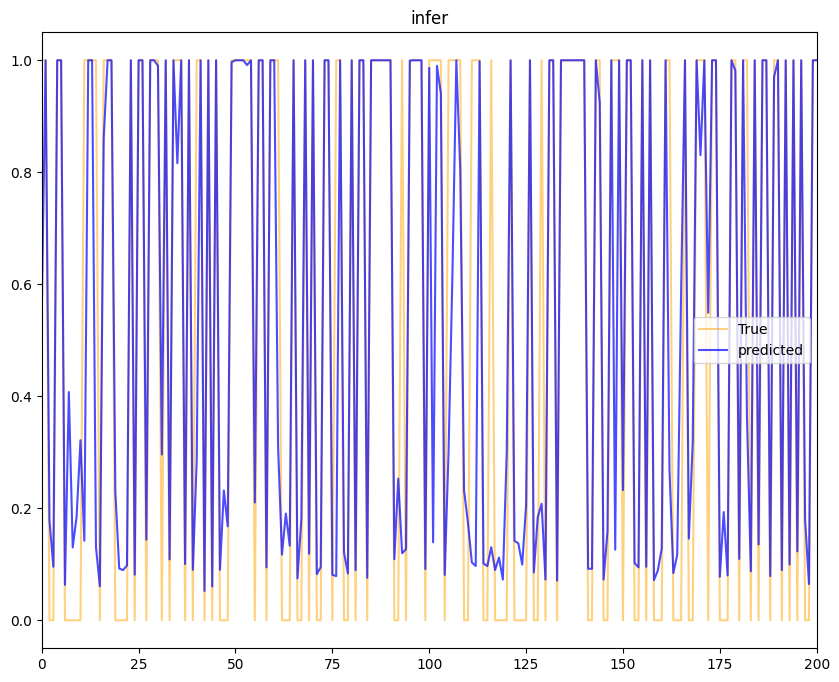

In [25]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [27]:
print(auc_keras)

0.950820450153864


In [ ]:
np.save("latest_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("latest_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("latest_results/thresholds_" + wireplane + "_train", thresholds_keras)

# Valid

In [ ]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

In [ ]:
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

In [ ]:
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

In [ ]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

In [ ]:
np.save("latest_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("latest_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("latest_results/thresholds_" + wireplane + "_valid", thresholds_keras)

In [ ]:
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc_keras,3)))
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

# test

In [ ]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


In [ ]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

In [ ]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [ ]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

In [ ]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

In [ ]:
plt.hist(all_infer_signal, range = (0,1), bins=20)